<h1> Scraping Imdb Movies Data</h1>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
from datetime import datetime
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from urllib.request import urlopen
from bs4 import BeautifulSoup
import requests
import textwrap

<h3> To web scrape the HTML document follow following steps:</h3>
    <ol>
        <li>Define a <b>get_data()</b>function which will input the page numbers as an argument</li>
        <li>Define a <b>headers</b> which will help in bypassing the detection as a scraper</li>
        <li>Specify the <b>URL</b> to requests.get() function and pass the headers variable as an argument</li>
        <li>Extract the response by requests.get(). It could be text or content.</li>
        <li>Scrape the specified page and assign it to <b>soup</b> variable</li>
        <li> All the pages we want to scrape have the same overall structure. This implies that they also have the same overall HTML structure. So, to write our script, it will suffice to understand the HTML structure of only one page. If you use Chrome, right-click on a web page element that interests you, and then click Inspect. This will take you right to the HTML line that corresponds to that element. Next step is to identify the parent tag under which all the data you need will reside. There are a lot of HTML lines nested within div/span tag. You can explore HTML lines corresponding to each div/span.</li>
        <li>There are many products shown per page, so there should be a div <b>container</b> for each. Before extracting these containers, we need to figure out what distinguishes them from other elements on that page. Often, the distinctive mark resides in the <b>class</b> attribute. Use the find_all() method to extract all the 'div' containers that have a class attribute 'lister-item mode-advanced'. <b>find_all()</b> returned a result set ('d') object which is a list containing all the containers we are interested in.</li>
        <li> Now select only the first container, and extract, by turn, each item of interest:
        <ul>
        <li>Movie Name</li>
        <li>Release year</li>
        <li>Runtime</li>
        <li>Rating</li>
        <li>Genre</li>
        <li>Metascore</li>
        <li>Votes</li>
        </ul>
        </li>
    </ol>

In [2]:
def get_data_movies():
    # To get header information of your browser. Follow the following steps:  
    # (1) visit a URL, right click, select Inspect to open the developer tools.
    # (2) Select Network tab
    # (3) Reload the page, select any HTTP request on the left panel i.e. Name, and the HTTP headers will be displayed on the right panel.
    #missing values in headers
    '''headers = { "DNT":"1","Connection":"close",}'''
    headers={
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/        *;q=0.8,application/signed-exchange;v=b3;q=0.9", 
        "Accept-Encoding": "gzip, deflate, br", 
        "Upgrade-Insecure-Requests": "1", 
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko)             Chrome/87.0.4280.88 Safari/537.36", 
    }
    url='https://www.imdb.com/search/title/?count=100&title_type=feature,tv_series?ref_=nv_wl_img_2'
    
    r=requests.get('https://www.imdb.com/search/title/?count=100&title_type=feature,tv_series?ref_=nv_wl_img_2')

    # requests.Response has following attributes:
    # (1) r.text is the content of the response in Unicode, and 
    # (2) r.content is the content of the response in bytes.
    content=r.content
    soup= BeautifulSoup(content)
    #print(soup)

    alls=[]
    for d in soup.findAll('div', attrs={'class':'lister-item mode-advanced'}):
        #movie_name=d.find('img')['alt']
        movie_name=d.h3.a
        release_year=d.h3.find('span',attrs={'class':'lister-item-year text-muted unbold'})
        run_time=d.p.find('span',attrs={'class':'runtime'})
        genre=d.p.find('span',attrs={'class':'genre'})
        rating=d.strong
        #rating=d.find('strong')
        metascore=d.find('span',attrs={'class':'metascore'})
        votes=d.find('span',attrs={'name':'nv'})

        all1=[]

        if movie_name is not None:
            all1.append(movie_name.text)
        else:
            all1.append("unknown-product")
        
        if release_year is not None:
            all1.append(release_year.text)
        else:
            all1.append('Not Mentioned')

        if run_time is not None:
            all1.append(run_time.text)
        else:
            all1.append('0')

        if genre is not None:
            all1.append(genre.text)
        else:
            all1.append('-1')

        if rating is not None:
            all1.append(float(rating.text))
        else:
            all1.append(0)

        if metascore is not None:
            all1.append(int(metascore.text))
        else:
            all1.append(0)
        
        if votes is not None:
            all1.append(votes.text)
        else:
            all1.append('0')

        alls.append(all1)
    return alls

In [3]:
results=[]
results.append(get_data_movies())

flatten=lambda l:[item for sublist in l for item in sublist]

df=pd.DataFrame(flatten(results),columns=['Movie_Name','Release_year','Runtime','Genre','Rating','Metascore','Votes'])
df.head()

,Movie_Name,Release_year,Runtime,Genre,Rating,Metascore,Votes
0,Outside the Wire,(2021),114 min,"\nAction, Adventure, Fantasy",5.4,45,"20,371"
1,Promising Young Woman,(2020),113 min,"\nCrime, Drama, Thriller",7.5,72,"19,459"
2,Cherry - Das Ende aller Unschuld,(2021),0,"\nCrime, Drama",0.0,0,0
3,One Night in Miami,(2020),114 min,\nDrama,7.3,83,"8,365"
4,Soul,(2020),100 min,"\nAnimation, Adventure, Comedy",8.1,83,"150,911"


In [4]:
df['Release_year'] = df['Release_year'].str[-5:-1]
df['Release_year']=pd.to_numeric(df['Release_year'])

In [5]:
df['Genre']=df['Genre'].replace('\n','', regex=True)

In [6]:
df['Runtime'] = df['Runtime'].map(lambda x: x.rstrip(' min'))

In [7]:
df['Votes']=df['Votes'].str.replace(',','')
df['Votes']=pd.to_numeric(df['Votes'])
df['Runtime']=pd.to_numeric(df['Runtime'])

In [8]:
df.dtypes

Movie_Name       object
Release_year      int64
Runtime           int64
Genre            object
Rating          float64
Metascore         int64
Votes             int64
dtype: object

In [9]:
df.head()

,Movie_Name,Release_year,Runtime,Genre,Rating,Metascore,Votes
0,Outside the Wire,2021,114,"Action, Adventure, Fantasy",5.4,45,20371
1,Promising Young Woman,2020,113,"Crime, Drama, Thriller",7.5,72,19459
2,Cherry - Das Ende aller Unschuld,2021,0,"Crime, Drama",0.0,0,0
3,One Night in Miami,2020,114,Drama,7.3,83,8365
4,Soul,2020,100,"Animation, Adventure, Comedy",8.1,83,150911


In [10]:
df = df[~(df == 0).any(axis=1)]

In [11]:
df.to_csv('imdb.csv',index=False, encoding='utf-8')
df_imdb=pd.read_csv('imdb.csv')
df_imdb.head()

,Movie_Name,Release_year,Runtime,Genre,Rating,Metascore,Votes
0,Outside the Wire,2021,114,"Action, Adventure, Fantasy",5.4,45,20371
1,Promising Young Woman,2020,113,"Crime, Drama, Thriller",7.5,72,19459
2,One Night in Miami,2020,114,Drama,7.3,83,8365
3,Soul,2020,100,"Animation, Adventure, Comedy",8.1,83,150911
4,Neues aus der Welt,2020,118,"Action, Adventure, Drama",6.9,73,10049


In [12]:
df_release=df_imdb[df_imdb['Release_year']==2020]
df_release= df_release.nlargest(10,'Rating')
df_release.head(10)

,Movie_Name,Release_year,Runtime,Genre,Rating,Metascore,Votes
3,Soul,2020,100,"Animation, Adventure, Comedy",8.1,83,150911
21,Der Rausch,2020,117,"Comedy, Drama",7.8,81,31793
33,The Trial of the Chicago 7,2020,129,"Drama, History, Thriller",7.8,77,87851
18,Nomadland,2020,108,Drama,7.6,96,9330
1,Promising Young Woman,2020,113,"Crime, Drama, Thriller",7.5,72,19459
6,Tenet,2020,150,"Action, Sci-Fi, Thriller",7.5,69,278068
67,Palm Springs,2020,90,"Comedy, Fantasy, Mystery",7.4,83,73275
2,One Night in Miami,2020,114,Drama,7.3,83,8365
8,Pieces of a Woman,2020,126,Drama,7.1,66,18673
15,The King of Staten Island,2020,136,"Comedy, Drama",7.1,67,35788


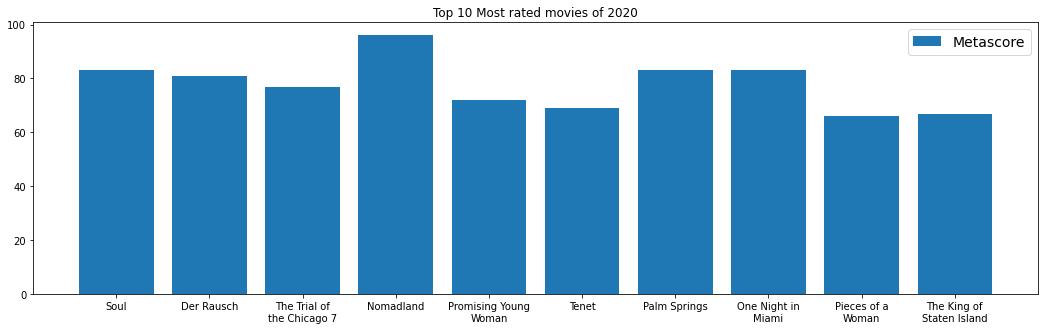

In [13]:
fig, ax = plt.subplots(figsize=(18,5)) # set the size that you'd like (width, height)
plt.bar([textwrap.fill(e, 15) for e in df_release['Movie_Name']], df_release['Metascore'], label = 'Metascore')
ax.legend(fontsize=14)
ax.set_title('Top 10 Most rated movies of 2020')
fig.show()